# Preparing Target Data

MendelImpute accepts [VCF](https://samtools.github.io/hts-specs/VCFv4.3.pdf) and [PLINK](https://www.cog-genomics.org/plink2/formats#bed) files. Please make sure the following are true:

+ VCF file ends in `.vcf` or `.vcf.gz` (phased or unphased and may contain missing data)
+ For PLINK files, all trios (`.bim`, `.bed`, `.fam`) are present in the same directory
+ Each file contains only 1 (non-sex) chromosome
+ Every record (SNP) is present in the reference panel. If this is untrue, you must [match markers in 2 VCF files](https://openmendel.github.io/VCFTools.jl/dev/man/conformgt/). 
+ Given a SNP, it's CHROM, POS, REF, and  ALT fields are the same in target data and reference panel. MendelImpute use SNP position internally to align markers. Note this is not explicitly checked. 
+ The position of every SNP is unique: so multiallelic markers should be excluded instead of split (this requirement will eventually be lifted). 

The following are not necessary but recommended for pre-imputation quality control:

+ Exclude markers with Hardy-Weinberg p-values $< 10^{-5}$. 
+ Exclude markers with minor allele frequency $< 10^{-6}$
+ Exclude samples with $>3\%$ missing genotypes

# Preparing Reference Haplotype Panel

Reference samples must all be phased and contain no missing genotypes. Reference VCF panels must be compressed into `.jlso` format first using the [compress_haplotypes](https://OpenMendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.compress_haplotypes) function. One must specify `d`: the maximum number of unique haplotypes per window. Larger `d` slows down computation, but increases accuracy. For most purposes, we recommend $d \approx 1000$. A larger `d` may be needed for TOPMed data. 

# Detailed Example

We use the [1000 genomes chromosome 22](http://bochet.gcc.biostat.washington.edu/beagle/1000_Genomes_phase3_v5a/b37.vcf/) as an example. As show below, this data contains 424147 SNPs and 2504 samples.

In [1]:
# load necessary packages in Julia
using VCFTools
using MendelImpute
using VCFTools
using Random

# compute simple summary statistics
data = "chr22.1kg.phase3.v5a.vcf.gz"
@show nrecords(data)
@show nsamples(data);

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1278


nrecords(data) = 424147
nsamples(data) = 2504


More summary statistics can be computed using the [gtstats](https://openmendel.github.io/VCFTools.jl/dev/man/api/#VCFTools.gtstats) function in `VCFTools.jl`, with example usage [here](https://openmendel.github.io/VCFTools.jl/dev/man/summaryinfo/#Summary-statistics).

## Step 1: generating realistic reference and target data 

First we generate a reference panel and imputation target based on the 1000 genomes data. More specifically, we take the 1000 genomes chromosome 22 and divide it so that 
+ 100 samples are randomly selected as imputation targets, where
    - 100k SNPs with minor allele frequency $\ge 0.05$ are randomly selected to be the typed positions. 
    - 0.1% of typed SNPs are masked (mimicking GWAS errors)
    - Genotypes are unphased
+ The remaining 2404 samples are used as reference haplotypes. 
+ SNPs with duplicate positions are filtered out.
+ All multiallelic markers are filtered out.

**Instruction: execute the code below in a Julia session or a Jupyter notebook:**

In [1]:
# set random seed for reproducibility
Random.seed!(2020)

# download example data 
data = "chr22.1kg.phase3.v5a.vcf.gz"
if !isfile(data) 
    download("http://bochet.gcc.biostat.washington.edu/beagle/1000_Genomes_phase3_v5a/b37.vcf/chr22.1kg.phase3.v5a.vcf.gz")
end

# remove SNPs with the same positions, keep all samples, save result into new file
SNPs_to_keep = .!find_duplicate_marker(data) 
@time VCFTools.filter(data, SNPs_to_keep, 1:nsamples(data), des = "chr22.uniqueSNPs.vcf.gz")

# summarize data
total_snps, samples, _, _, _, maf_by_record, _ = gtstats("chr22.uniqueSNPs.vcf.gz")

# generate target file with 100 samples and 100k snps with maf>0.05
n = 100
p = 100000
record_idx = falses(total_snps)
large_maf = findall(x -> x > 0.05, maf_by_record)  
Random.shuffle!(large_maf)
record_idx[large_maf[1:p]] .= true
sample_idx = falses(samples)
sample_idx[1:n] .= true
Random.shuffle!(sample_idx)
@time VCFTools.filter("chr22.uniqueSNPs.vcf.gz", record_idx, sample_idx, 
    des = "target.chr22.typedOnly.vcf.gz", allow_multiallelic=false)

# unphase and mask 0.1% entries in target file
masks = falses(p, n)
missingprop = 0.001
for j in 1:n, i in 1:p
    rand() < missingprop && (masks[i, j] = true)
end
@time mask_gt("target.chr22.typedOnly.vcf.gz", masks, 
    des="target.chr22.typedOnly.masked.vcf.gz", unphase=true)

# generate target panel with all snps (this file contains true phase and genotypes)
@time VCFTools.filter("chr22.uniqueSNPs.vcf.gz", 1:total_snps, 
    sample_idx, des = "target.chr22.full.vcf.gz", allow_multiallelic=false)

# generate reference panel with 2404 samples
@time VCFTools.filter("chr22.uniqueSNPs.vcf.gz", 1:total_snps, .!sample_idx, 
    des = "ref.chr22.excludeTarget.vcf.gz", allow_multiallelic=false)

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1278
finding duplicate markers...100%|███████████████████████| Time: 0:03:56
filtering vcf file...100%|██████████████████████████████| Time: 0:04:46


292.131527 seconds (3.20 G allocations: 301.789 GiB, 7.89% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:04:02
filtering vcf file...100%|██████████████████████████████| Time: 0:03:59


244.425505 seconds (3.18 G allocations: 301.694 GiB, 9.69% gc time)
  1.935526 seconds (20.00 M allocations: 1.491 GiB, 6.33% gc time)


filtering vcf file...100%|██████████████████████████████| Time: 0:04:10


255.505399 seconds (3.27 G allocations: 317.749 GiB, 9.95% gc time)


filtering vcf file...100%|██████████████████████████████| Time: 0:07:27


453.383147 seconds (6.16 G allocations: 566.535 GiB, 10.16% gc time)


### Output explanation:

You just generated reference and target VCF files:

+ `ref.chr22.excludeTarget.vcf.gz`: Reference haplotype panel with 2404 samples
+ `target.chr22.typedOnly.masked.vcf.gz`: Imputation target file containing 100 samples at 100k SNPs. All genotypes are unphased and contains 0.1% missing data. 

You also generated/downloaded:

+ `chr22.1kg.phase3.v5a.vcf.gz`: The original chromosome 22 data downloaded from Beagle's website.
+ `chr22.uniqueSNPs.vcf.gz`: This is the original chromosome 22 data excluding duplicate records (SNPs) by checking marker positions. The first SNP is included but all subsequent SNPs are removed. 
+ `target.chr22.full.vcf.gz`: The complete data for imputation target, used for checking imputation accuracy. All genotypes are phased and non-missing. 
+ `target.chr22.typedOnly.vcf.gz`: Complete target data on just the typed SNPs. All genotypes are phased and non-missing. Just by-producted for generating other files; not used for anything downstream.

## Step 2: generating `.jlso` compressed reference panel

MendelImpute requires one to pre-process the reference panel for faster reading. This is achieved via the [compress_haplotypes](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.compress_haplotypes) function.

In [2]:
# load necessary packages in Julia
using MendelImpute

max_d = 1000 # maximum number of unique haplotypes per window
reffile = "ref.chr22.excludeTarget.vcf.gz"
tgtfile = "target.chr22.typedOnly.masked.vcf.gz"
outfile = "ref.chr22.maxd1000.excludeTarget.jlso"
@time compress_haplotypes(reffile, tgtfile, outfile, max_d)

importing reference data...100%|████████████████████████| Time: 0:02:00


295.546081 seconds (2.09 G allocations: 209.215 GiB, 10.53% gc time)


## Step 3: Run imputation and phasing

Below runs the main [phase](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.phase) function in a single thread. By default all output genotypes will be phased and non-missing. A list of optional inputs can be found in the [API](https://openmendel.github.io/MendelImpute.jl/dev/man/api/#MendelImpute.phase).

In [3]:
# note: run twice for more accurate timing
reffile = "ref.chr22.maxd1000.excludeTarget.jlso" # jlso reference file
tgtfile = "target.chr22.typedOnly.masked.vcf.gz"  # target genotype file
outfile = "mendel.imputed.chr22.vcf.gz"           # output file name
phase(tgtfile, reffile, outfile);

Number of threads = 1
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:20


Total windows = 1634, averaging ~ 508 unique haplotypes per window.

Timings: 
    Data import                     = 10.1839 seconds
        import target data             = 1.78449 seconds
        import compressed haplotypes   = 8.39945 seconds
    Computing haplotype pair        = 20.8186 seconds
        BLAS3 mul! to get M and N      = 1.09855 seconds per thread
        haplopair search               = 19.2442 seconds per thread
        initializing missing           = 0.100835 seconds per thread
        allocating and viewing         = 0.284366 seconds per thread
        index conversion               = 0.0800866 seconds per thread
    Phasing by win-win intersection = 4.06343 seconds
        Window-by-window intersection  = 0.536747 seconds per thread
        Breakpoint search              = 3.24288 seconds per thread
        Recording result               = 0.269504 seconds per thread
    Imputation                     = 2.99534 seconds
        Imputing missing               = 0

The `;` hides the output, or else the screen will be too jammed. 

!!! note

    To run MendelImpute in parallel, type `export JULIA_NUM_THREADS=4` **before** starting Julia. See Performance Gotchas #1 on the left for details.

## Step 3.5: (only for simulated data) check imputation accuracy

Since we simulated data, we can check imputation accuracy.

In [6]:
X_truth  = convert_gt(Float64, "target.chr22.full.vcf.gz")    # import true genotypes
X_mendel = convert_gt(Float64, "mendel.imputed.chr22.vcf.gz") # import imputed genotypes
n, p = size(X_mendel)
println("error overall = ", sum(X_mendel .!= X_truth) / n / p)

error overall = 0.00527504782243333


## Post-imputation: per-SNP Imputation Quality Score

By default, MendelImpute outputs a per-SNP imputation quality score. A score of 1 is best, 0 is worst. It is the percentage number of samples where the 2 chosen haplotypes match the observed genotype. For untyped (i.e. imputed) SNPs, the quality score is the average of the closest 2 typed SNP's score.

To extract this score from a VCF file, we recommend the following. We will develop a better pipeline for importing this quality score if someone demands it from us. 

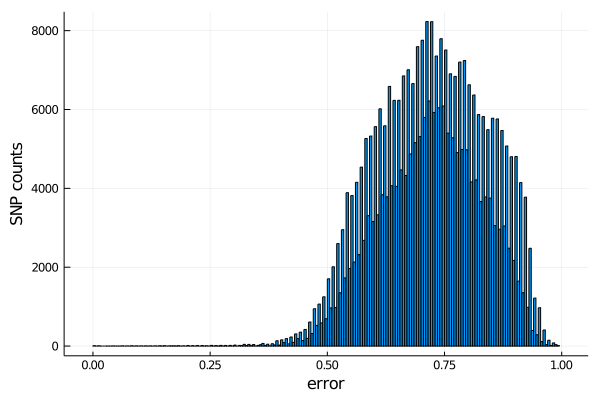

In [8]:
# plot histogram of SNP scores
using Plots
histogram(snpscores, label=:none, xlabel="error", ylabel="SNP counts")

**Conclusion:** Most SNPs have imputation quality $> 0.5$, but some have quality score below $0.5$. We recommend those SNPs to be [filtered out](https://openmendel.github.io/VCFTools.jl/dev/man/filter/#Subsetting-VCF-files-using-array-masks). 

Note the popular correlation metric $r^2$ such as [this one](https://genome.sph.umich.edu/wiki/Minimac3_Info_File#Rsq) is NOT a good metric for measuring imputation accuracy under MendelImpute's model, because all imputed SNPs will have $r^2 = 1$. For details, please see our paper. 

## Post-imputation: per-sample Imputation Quality score

MendelImpute also computes a rough quality score (file ending in `sample.error`) for measuring how well each sample is imputed. This value is the sum of the least squares error in each window. A value of 0 is best, and high values mean worse. For more detail, please refer to our paper. 

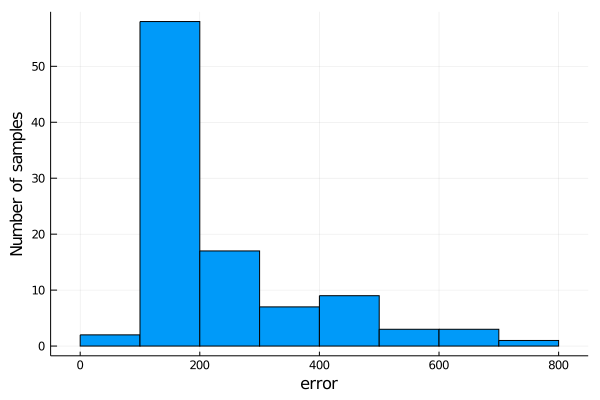

In [7]:
using CSV
quality = CSV.read("mendel.imputed.chr22.sample.error") # import quality score 

# visualize error distribution
histogram(quality[:error], label=:none, xlabel="error", ylabel="Number of samples") 

We want this histogram to look like this: most samples have small error (e.g. less than 200), indicating they are relatively well imputed. Only a few have large errors. A histogram with large right tail indicates poor imputation. 